In [24]:
# ========================
# 1. IMPORT LIBRARIES
# ========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Plot settings
sns.set(style='whitegrid')
%matplotlib inline

In [25]:
# ========================
# 2. LOAD DATA
# ========================
fraud_data = pd.read_csv('../data/Fraud_Data.csv')
ip_country = pd.read_csv('../data/IpAddress_to_Country.csv')
creditcard_data = pd.read_csv('../data/creditcard.csv')

In [26]:
# ========================
# 3. INITIAL CHECKS
# ========================
print("Missing values:\n", fraud_data.isnull().sum())
print("\nDuplicate rows:", fraud_data.duplicated().sum())

# Drop duplicates
fraud_data.drop_duplicates(inplace=True)

# Drop rows with missing IPs
fraud_data = fraud_data[fraud_data['ip_address'].notna()]

Missing values:
 user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

Duplicate rows: 0


In [27]:
# ========================
# 4. FIX DATA TYPES
# ========================
# Convert time columns
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])

# Convert IP address to integer
fraud_data['ip_int'] = fraud_data['ip_address'].astype(float).astype(int)

# Convert IP bounds to integers
ip_country['lower_bound_ip_address'] = ip_country['lower_bound_ip_address'].astype(float).astype(int)
ip_country['upper_bound_ip_address'] = ip_country['upper_bound_ip_address'].astype(float).astype(int)

# Sort IP data
ip_country = ip_country.sort_values('lower_bound_ip_address').reset_index(drop=True)

In [28]:
# ========================
# 5. MERGE IPs TO COUNTRY
# ========================
def find_country(ip, ip_df):
    left, right = 0, len(ip_df) - 1
    while left <= right:
        mid = (left + right) // 2
        row = ip_df.iloc[mid]
        if row['lower_bound_ip_address'] <= ip <= row['upper_bound_ip_address']:
            return row['country']
        elif ip < row['lower_bound_ip_address']:
            right = mid - 1
        else:
            left = mid + 1
    return 'Unknown'

# Map country
fraud_data['country'] = fraud_data['ip_int'].apply(lambda x: find_country(x, ip_country))

In [29]:
# ========================
# 6. FEATURE ENGINEERING
# ========================

# Time-based features
fraud_data['hour_of_day'] = fraud_data['purchase_time'].dt.hour
fraud_data['day_of_week'] = fraud_data['purchase_time'].dt.dayofweek
fraud_data['time_since_signup'] = (
    fraud_data['purchase_time'] - fraud_data['signup_time']
).dt.total_seconds() / 3600  # in hours

# Transaction frequency
user_freq = fraud_data.groupby('user_id').size().rename('user_txn_count')
device_freq = fraud_data.groupby('device_id').size().rename('device_txn_count')

fraud_data = fraud_data.merge(user_freq, on='user_id', how='left')
fraud_data = fraud_data.merge(device_freq, on='device_id', how='left')

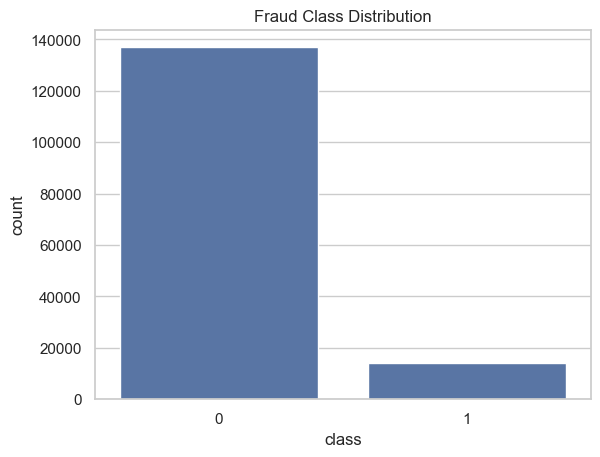

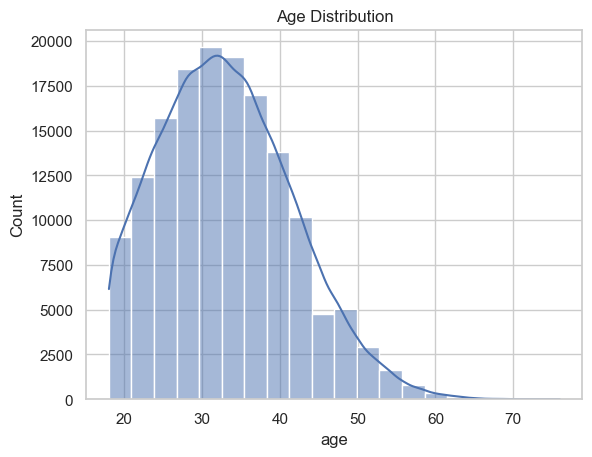

In [30]:
# ========================
# 7. EDA - UNIVARIATE
# ========================
# Class distribution
sns.countplot(data=fraud_data, x='class')
plt.title('Fraud Class Distribution')
plt.show()

# Age distribution
sns.histplot(fraud_data['age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.show()

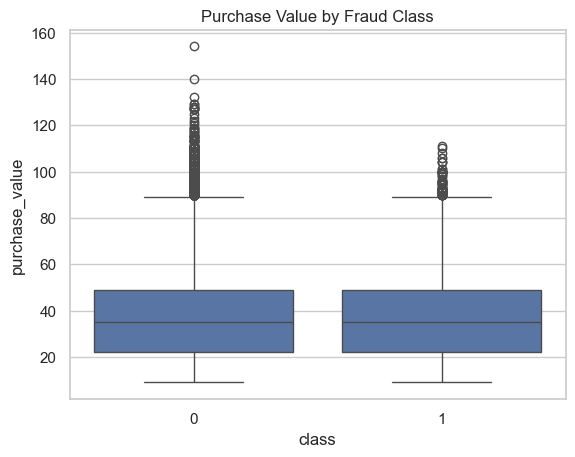

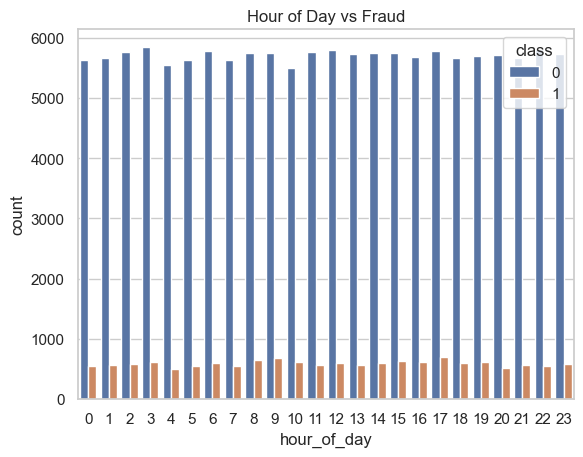

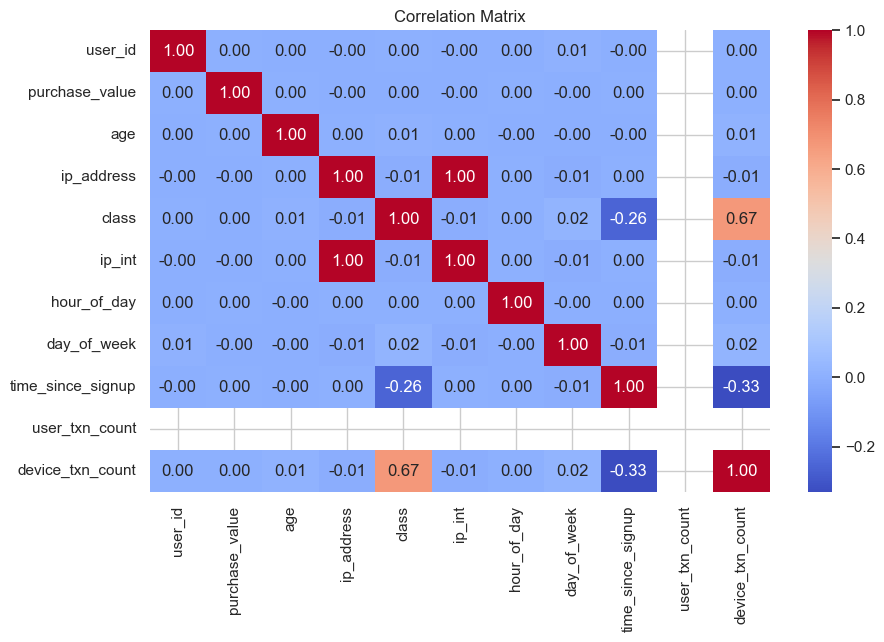

In [32]:
# ========================
# 8. EDA - BIVARIATE
# ========================
# Purchase value by class
sns.boxplot(data=fraud_data, x='class', y='purchase_value')
plt.title('Purchase Value by Fraud Class')
plt.show()

# Hour of day vs fraud
sns.countplot(data=fraud_data, x='hour_of_day', hue='class')
plt.title('Hour of Day vs Fraud')
plt.show()

# Correlation matrix
corr = fraud_data.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [33]:
# ========================
# 9. NORMALIZATION / SCALING
# ========================
scaler = StandardScaler()
fraud_data[['purchase_value', 'time_since_signup']] = scaler.fit_transform(
    fraud_data[['purchase_value', 'time_since_signup']]
)

In [34]:
# ========================
# 10. ENCODE CATEGORICAL FEATURES
# ========================
fraud_data = pd.get_dummies(fraud_data, columns=['source', 'browser', 'sex', 'country'], drop_first=True)

In [35]:
# ========================
# 11. CLASS IMBALANCE CHECK
# ========================
class_dist = fraud_data['class'].value_counts(normalize=True)
print("Class Distribution:\n", class_dist)

# NOTE: Handle with SMOTE or under-sampling later after splitting into train/test


Class Distribution:
 class
0    0.906354
1    0.093646
Name: proportion, dtype: float64


In [37]:
fraud_data.to_csv('../data/fraud_data_preprocessed.csv', index=False)
